In [1]:
#Conectando google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


___Obs___: Están todas las funciones desordenadas, el notebook debería ir así:

1. _Descarga Roboflow_
2. _Formación Máscaras Data Segmentación_
3. _Funciones Data Mask_
4. _Guardando Imágenes_
5. _Formar Dataset para Modelo_
6. _Funciones Opacidad_
7. _Resultados Opacidad_
8. _Funciones Bounding Box_
9. _Resultados Bounding Box_

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random as rd

### Descarga Roboflow

In [3]:
#Descargamos nuestra data etiquetada en Roboflow a nuestra carpeta del repositorio de YOLOv7
%cd /content/gdrive/MyDrive/Vision_Matcom/Deteccion_Penacho/segmentation_model

#Usamos el etiquetado de roboflow para descargar las imagenes a traves de su api
#Se quita (llave, espacio de trabajo y proyecto)
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key = "")
project = rf.workspace("").project("")
dataset = project.version(1).download("coco-segmentation")

/content/gdrive/MyDrive/Vision_Matcom/Deteccion_Penacho/segmentation_model
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to segmentation_pellets-1 in coco-segmentation:: 100%|██████████| 1445/1445 [00:17<00:00, 83.88it/s]


### Ordenando Dataset

In [4]:
%cd /content/gdrive/MyDrive/Vision_Matcom/Deteccion_Penacho/segmentation_model/segmentation_pellets-1
%ls

/content/gdrive/MyDrive/Vision_Matcom/Deteccion_Penacho/segmentation_model/segmentation_pellets-1
README.dataset.txt  README.roboflow.txt  test/  train/  valid/


In [5]:
%rm README.dataset.txt README.roboflow.txt
%mkdir Primera_Images Primera_Masks
%ls

Primera_Images/  Primera_Masks/  test/  train/  valid/


In [6]:
def traspass_images(folder_original, folder_final):
  #Guardamos nombre imagenes
  list_names_images = [name_image for name_image in os.listdir(folder_original) if '.jpg' in name_image]
  #Abrimos imagenes
  list_images = [cv2.imread(folder_original + image) for image in list_names_images]
  #Guardamos imagenes en la nueva carpeta
  for image, name_image in zip(list_images, list_names_images):
    cv2.imwrite(f'{folder_final}/{name_image}', image)
  print(f'Imagenes copiadas en {folder_final}')

In [7]:
#Traspasamos las imagenes a una carpeta comun (Esto dado la mal distribucion de las imagenes que quedo en roboflow)
imagenes_train = len(os.listdir('train/')) - 1
traspass_images('train/', 'Primera_Images/')
imagenes_valid = len(os.listdir('valid/')) - 1
traspass_images('valid/', 'Primera_Images/')
imagenes_test = len(os.listdir('test/')) - 1
traspass_images('test/', 'Primera_Images/')

print(f'Total imagenes en carpeta nueva: {len(os.listdir("Primera_Images/"))}')
print(f'Total imagenes: {len(os.listdir("Primera_Images/"))}')

Imagenes copiadas en Primera_Images/
Imagenes copiadas en Primera_Images/
Imagenes copiadas en Primera_Images/
Total imagenes en carpeta nueva: 1437
Total imagenes: 1437


In [8]:
#Considerando que las clases son:
# 0 - SKY
# 1 - LAND
# 2 - POND
# 3 - SMOKE
#(fijarse en el orden de las mascaras cuando se exporten)

def type_coordinates(list_coordinates):
  '''
  Esta funcion forma una lista de a pares para las coordenadas del etiquetado
  puesto que en COCO viene [[eje_x1, eje_y1, eje_x2, eje_y2, ...], ...], y se entrega
  de la forma [[(eje_x1, eje_y1), (eje_x2, eje_y2), ...], ...].

  Inputs:
        list_coordinates List() = lista de coordenadas COCO.

  Outputs:
        list_final List() = lista de lista de pares de coordenadas.
  '''
  #Lista de coordenadas
  list_final = []
  for lista in list_coordinates:
    largo = len(lista)
    list_aux = []
    for i in range(0, largo, 2):
      #Se forma lista de a pares, eje_x, eje_y
      list_aux.append([lista[i], lista[i + 1]])
    list_final.append(list_aux)
  return list_final

def cocoset_to_dict(dict_data):
  '''
  Esta funcion ordena de manera mas intuitiva los datos etiquetados en formato COCO,
  extrayendo solo la informacion necesaria para formar las mascaras de las imagenes
  etiquetadas en roboflow.

  Inputs:
        dict_data Dict() = diccionario con toda la informacion del etiquetado, este
                           tiene el siguiente formato
                           {"info" : {...},
                            "licenses" : [...],
                            "categories" : [{"id" : ..., ...}, ...],
                            "images" : [{"id" : ..., "file_name" : ..., ...}, ...],
                            "annotations" : [{"image_id" : ..., "category_id" : ...,
                                              "segmentation" : [[...]]}], ...}

  Outputs:
        dict_final Dict() = diccionario con la informacion de segmentacion, para la
                            formacion de mascaras, el cual tiene el siguiente formato
                            {"nombre_imagen":
                                {"segmentation_(num_mascara)" : [lista_pares_coordenadas],
                                 ...}, ...}
                            con esto se tiene la info del numero para la mascara (en el
                            num_mascara), se tiene el nombre y las coordenadas en pares.
  '''
  #Se forma el par (nombre_imagen, id_imagen)
  images = [(dictionary['file_name'], dictionary['id']) for dictionary in dict_data['images']]
  #Se toma la lista de las anotaciones
  annotations = dict_data['annotations']
  dict_final = dict()
  #Se recorre nombre e id de las imagenes
  for name_image, id_image in images:
    dict_aux = dict()
    #Se recorre las anotaciones
    for anno in annotations:
      #Si tienen el mismo id de imagen en el dict de anotaciones, se forma el dict de segmentacion
      if anno['image_id'] == id_image:
        coordenadas = type_coordinates(anno['segmentation'])
        if f'segmentation_{anno["category_id"]}' in dict_aux:
          dict_aux[f'segmentation_{anno["category_id"]}'] = dict_aux[f'segmentation_{anno["category_id"]}'] + coordenadas
        else:
          dict_aux[f'segmentation_{anno["category_id"]}'] = coordenadas
    #Se agregan los dict de segmentaciones al dict final
    dict_final[name_image] = dict_aux
  return dict_final

#----------------------------------------------------------------------------------------------

def mask_form(dictionary, root_mask, shape_mask = (1050, 1680)):
  '''
  Esta funcion se encarga de formar la mascara de segmentacion de los datos etiquetados COCO,
  y guardar la imagen respectiva para entrenar los modelos

  Inputs:
        dictionary Dict() = dict intuitivo formado por la funcion "cocoset_to_dict()"
        root_mask str() = ruta donde se guardaran las mascaras creadas
        shape_mask = dimensiones de las mascaras (estas deben tener la misma dimension de las
                     imagenes), pero se trabajara con una dimension ya dada
                     (1050 pixeles de alto y 1680 de ancho)

  Outputs:
        No tiene output (se debe cambiar la lista final, para que solo guarde la imagen
        con cv2.imwrite(root_mask, mascara, nombre_imagen_original, ...) )
  '''
  list_final = []
  #Recorremos llave y diccionario
  for llave, dictio in dictionary.items():
    #Se forma una imagen vacia
    image_aux = np.zeros(shape_mask, dtype = np.uint8)
    #Se recorren las distintas segmentaciones formadas (numero representativo segmentacion, coors)
    for segmentacion, coordenadas in dictio.items():
      #Numero de la segmentacion para ingresar a la imagen
      num_mask = int(segmentacion[-1])
      #Recorremos las distintas coordenadas
      for coors in coordenadas:
        #Formamos el poligono cerrado relleno de las coordenadas
        coors = np.array(coors, dtype = np.int32).reshape((-1, 1, 2))
        cv2.fillPoly(image_aux, [coors], color = (num_mask, num_mask, num_mask))
    #Guardamos mascara
    cv2.imwrite(f'{root_mask}/{llave}', image_aux)
  print('Imagenes guardadas!')

In [9]:
#Formamos diccionario comodo para formacion de segmentaciones train
ruta = 'train/'
with open(f'{ruta}_annotations.coco.json', 'r') as json_file:
  data = json.load(json_file)

dict_labels = cocoset_to_dict(data)
#Vemos algunos ejemplos de como queda
list(dict_labels.items())[: 10]

[('dispersion_lateral_1688_jpg.rf.f477c990ca95141cdb387d2f53df1b83.jpg',
  {'segmentation_1': [[[1680, 923.672],
     [1635.703, 905.625],
     [1619.297, 892.5],
     [1609.453, 892.5],
     [1563.516, 872.813],
     [1556.953, 872.813],
     [1530.703, 892.5],
     [1511.016, 899.063],
     [1471.641, 899.063],
     [1438.828, 885.938],
     [1422.422, 892.5],
     [1386.328, 892.5],
     [1383.047, 889.219],
     [1360.078, 889.219],
     [1343.672, 882.656],
     [1320.703, 882.656],
     [1287.891, 899.063],
     [1258.359, 899.063],
     [1245.234, 892.5],
     [1235.391, 892.5],
     [1209.141, 872.813],
     [1182.891, 866.25],
     [1173.047, 859.688],
     [1153.359, 859.688],
     [1130.391, 872.813],
     [1087.734, 879.375],
     [1054.922, 899.063],
     [1028.672, 899.063],
     [1012.266, 908.906],
     [989.297, 908.906],
     [959.766, 918.75],
     [943.359, 918.75],
     [917.109, 908.906],
     [858.047, 912.188],
     [841.641, 905.625],
     [756.328, 902.344],
 

In [10]:
#Formamos y guardamos segmentaciones train
mask_form(dict_labels, 'Primera_Masks')
print(f'Total mascaras: {len(os.listdir("Primera_Masks/"))}')

Imagenes guardadas!
Total mascaras: 1257


In [11]:
#Formamos diccionario comodo para formacion de segmentaciones validacion
ruta = 'valid/'
with open(f'{ruta}_annotations.coco.json', 'r') as json_file:
  data = json.load(json_file)

dict_labels = cocoset_to_dict(data)
#Vemos algunos ejemplos de como queda
list(dict_labels.items())[: 5]

[('dispersion_lateral_1739_jpg.rf.09fd8560805af9201684e42cfb0f1c3b.jpg',
  {'segmentation_1': [[[1680, 923.672],
     [1675.078, 918.75],
     [1665.234, 918.75],
     [1635.703, 905.625],
     [1619.297, 892.5],
     [1609.453, 892.5],
     [1560.234, 872.813],
     [1550.391, 876.094],
     [1530.703, 892.5],
     [1511.016, 899.063],
     [1471.641, 899.063],
     [1438.828, 885.938],
     [1422.422, 892.5],
     [1386.328, 892.5],
     [1383.047, 889.219],
     [1360.078, 889.219],
     [1343.672, 882.656],
     [1323.984, 882.656],
     [1287.891, 899.063],
     [1258.359, 899.063],
     [1235.391, 892.5],
     [1199.297, 869.531],
     [1182.891, 866.25],
     [1173.047, 859.688],
     [1156.641, 859.688],
     [1130.391, 872.813],
     [1117.266, 872.813],
     [1081.172, 882.656],
     [1071.328, 892.5],
     [1054.922, 899.063],
     [1028.672, 899.063],
     [1012.266, 908.906],
     [989.297, 908.906],
     [966.328, 918.75],
     [940.078, 918.75],
     [926.953, 912.188],


In [12]:
#Formamos y guardamos segmentaciones validacion
mask_form(dict_labels, 'Primera_Masks')
print(f'Total mascaras: {len(os.listdir("Primera_Masks/"))}')

Imagenes guardadas!
Total mascaras: 1377


In [13]:
#Formamos diccionario comodo para formacion de segmentaciones test
ruta = 'test/'
with open(f'{ruta}_annotations.coco.json', 'r') as json_file:
  data = json.load(json_file)

dict_labels = cocoset_to_dict(data)
#Vemos algunos ejemplos de como queda
list(dict_labels.items())[: 5]

[('dispersion_lateral_1687_jpg.rf.3216b1f42892e019eeeceacbe2f64d30.jpg',
  {'segmentation_1': [[[1680, 923.672],
     [1635.703, 905.625],
     [1619.297, 892.5],
     [1609.453, 892.5],
     [1563.516, 872.813],
     [1556.953, 872.813],
     [1530.703, 892.5],
     [1511.016, 899.063],
     [1471.641, 899.063],
     [1438.828, 885.938],
     [1422.422, 892.5],
     [1386.328, 892.5],
     [1383.047, 889.219],
     [1360.078, 889.219],
     [1343.672, 882.656],
     [1320.703, 882.656],
     [1287.891, 899.063],
     [1258.359, 899.063],
     [1245.234, 892.5],
     [1235.391, 892.5],
     [1209.141, 872.813],
     [1182.891, 866.25],
     [1173.047, 859.688],
     [1153.359, 859.688],
     [1130.391, 872.813],
     [1087.734, 879.375],
     [1054.922, 899.063],
     [1028.672, 899.063],
     [1012.266, 908.906],
     [989.297, 908.906],
     [959.766, 918.75],
     [943.359, 918.75],
     [917.109, 908.906],
     [858.047, 912.188],
     [841.641, 905.625],
     [756.328, 902.344],
 

In [14]:
#Formamos y guardamos segmentaciones test
mask_form(dict_labels, 'Primera_Masks')
print(f'Total mascaras: {len(os.listdir("Primera_Masks/"))}')

Imagenes guardadas!
Total mascaras: 1437


In [16]:
#Revisamos si tienen las mismas imagenes o si hay alguno que tenga mas (Aprovechando que se guardan con el mismo nombre)
list_imgs = os.listdir('Primera_Images/')
list_masks = os.listdir('Primera_Masks/')

print('------------------------- Imagenes -------------------------')
for i in list_imgs:
  if i not in list_masks:
    print(i)
print('------------------------------------------------------------')
print('------------------------- Mascaras -------------------------')
for j in list_masks:
  if j not in list_imgs:
    print(j)
print('------------------------------------------------------------')
print(f'Total imagenes: {len(list_imgs)}')
print(f'Total mascaras: {len(list_masks)}')

------------------------- Imagenes -------------------------
------------------------------------------------------------
------------------------- Mascaras -------------------------
------------------------------------------------------------
Total imagenes: 1437
Total mascaras: 1437


In [17]:
%mkdir XTrain XVal XTest yTrain yVal yTest
%rm -r train test valid
%ls

Primera_Images/  Primera_Masks/  XTest/  XTrain/  XVal/  yTest/  yTrain/  yVal/


In [18]:
#Desordenamos las imagenes
rd.shuffle(list_masks)
largo = len(list_masks)

#Separamos datos Train, Valid y Test
list_masks_train = list_masks[: int(0.7 * largo)]
list_masks_valid = list_masks[int(0.7 * largo) : int(0.9 * largo)]
list_masks_test = list_masks[int(0.9 * largo) :]

print(f'Lista Original: {len(list_masks)}')
print('------------------------------------')
print(f'Lista Train: {len(list_masks_train)}')
print(f'Lista Valid: {len(list_masks_valid)}')
print(f'Lista Test: {len(list_masks_test)}')
print(f'Suma Listas: {len(list_masks_train) + len(list_masks_valid) + len(list_masks_test)}')

Lista Original: 1437
------------------------------------
Lista Train: 1005
Lista Valid: 288
Lista Test: 144
Suma Listas: 1437


In [19]:
def images_data(path_save, path_load, list_names, flag = 0):
  #Si el flag es 0, se guardan las imagenes RGB
  if flag == 0:
    #Se lee la lista de nombres y se abre la imagen en BGR
    list_images = [cv2.imread(f'{path_load}/{image}') for image in list_names]
    #Se recorre imagen y nombre de la imagen
    for image, name in zip(list_images, list_names):
      #Se guarda con nombre y ruta establecida
      cv2.imwrite(f'{path_save}/{name}', image)
    print('Imagenes Guardadas!')
  #Si el flag es 1, se guardan las mascaras de segmentacion
  elif flag == 1:
    #Se lee la lista de nombres y se abre la mascara en escala de grises
    list_masks = [cv2.imread(f'{path_load}/{mask}', 0) for mask in list_names]
    #Se recorre mascara y nombre de la mascara
    for mask, name in zip(list_masks, list_names):
      #Se guarda con nombre y ruta establecida
      cv2.imwrite(f'{path_save}/{name}', mask)
    print('Mascaras Guardadas!')

In [21]:
#Guardamos imagenes y mascaras de testeo
images_data('XTest', 'Primera_Images', list_masks_test, flag = 0)
images_data('yTest', 'Primera_Masks', list_masks_test, flag = 1)
print(f'{len(os.listdir("XTest/"))}')
print(f'{len(os.listdir("yTest/"))}')

144
144


In [22]:
#Guardamos imagenes y mascaras de validacion
images_data('XVal', 'Primera_Images', list_masks_valid, flag = 0)
images_data('yVal', 'Primera_Masks', list_masks_valid, flag = 1)
print(f'{len(os.listdir("XVal/"))}')
print(f'{len(os.listdir("yVal/"))}')

Imagenes Guardadas!
Mascaras Guardadas!
288
288


In [23]:
#Guardamos imagenes y mascaras de entrenamiento
images_data('XTrain', 'Primera_Images', list_masks_train, flag = 0)
images_data('yTrain', 'Primera_Masks', list_masks_train, flag = 1)
print(f'{len(os.listdir("XTrain/"))}')
print(f'{len(os.listdir("yTrain/"))}')

Imagenes Guardadas!
Mascaras Guardadas!
1005
1005


### Funciones Opacidad

Se forman funciones de distintos métodos de calcular la opacidad de gases.

Estos métodos de opacidad fueron estudiados en el siguiente documento:

* ___Fully automated method to estimate opacity in stack and fugitive emissions: A case study in industrial environments___. _Oscar D. Pedrayes, Rub ́en Usamentiaga, Daniel F. García_.


In [24]:
#Funciones para la opacidad
#----------------------------------------------------------------------------------------
def rgb_mask(imagen, mask_per_class):
  img1 = mask_per_class * imagen[:, :, 0]
  img2 = mask_per_class * imagen[:, :, 1]
  img3 = mask_per_class * imagen[:, :, 2]
  img = cv2.merge([img1, img2, img3])
  return img
#----------------------------------------------------------------------------------------
def gray_mask(imagen, mask_per_class):
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  img = mask_per_class * imagen
  return img
#----------------------------------------------------------------------------------------
def normalize_and_opacity_final(smoke, range_pixels):
  #Rango de normalizacion
  norm = range_pixels[1] - range_pixels[0]
  for i in range(0, 1050):
    for j in range(0, 1680):
      #Si esta dentro de la mascara
      if smoke[i, j] != 0:
        #Se normalizan los valores y luego se calcula el porcentaje de opacidad
        smoke[i, j] = 1 - (smoke[i, j] - range_pixels[0]) / norm
  return smoke
#----------------------------------------------------------------------------------------
def opacity_sbpb(mask, image):
  #Esto es para imagenes en bgr
  #Mascara (1s en etiqueta, 0s otros)
  sky = np.where(mask == 0, 1, 0)
  pond = np.where(mask == 2, 1, 0)
  smoke = np.where(mask == 3, 1, 0)
  #Separaciones del RGB
  sky_rgb = rgb_mask(image, sky)
  pond_rgb = rgb_mask(image, pond)
  smoke_rgb = rgb_mask(image, smoke)
  #Sacamos los pixeles 0s de la distribucion
  sky_b = sky_rgb[:, :, 0]
  pond_b = pond_rgb[:, :, 0]
  smoke_b = smoke_rgb[:, :, 0]
  sky_b_per = sky_b[sky_b > 0]
  pond_b_per = pond_b[pond_b > 0]
  #Rango para la opacidad
  rango = (np.percentile(pond_b_per, 25), np.percentile(sky_b_per, 75))
  #Opacidad por pixel
  smoke_b = np.where((smoke_b > 0) & (smoke_b <= rango[0]), rango[0], smoke_b)
  smoke_b = np.where((smoke_b > rango[1]), rango[1], smoke_b)
  smoke_b = normalize_and_opacity_final(smoke_b, rango)
  #Print resumen estadistico de la opacidad
  one_channel_resume_statistics(smoke_b)
  return smoke_b
#----------------------------------------------------------------------------------------
def opacity_dom(mask, image, K = 1.4): #Plumas: (blancas K = 1.4, negras K = 0.16)
  #Mascara (1s en etiqueta, 0s otros)
  sky = np.where(mask == 0, 1, 0)
  smoke = np.where(mask == 3, 1, 0)
  #Separaciones del RGB
  sky_gray = gray_mask(image, sky)
  smoke_gray = gray_mask(image, smoke)
  #Average background sky
  N = np.mean(sky_gray[sky_gray > 0])
  #Opacidad por pixel
  smoke_gray = formule_opacity_dom(smoke_gray, N, 1 - K)
  #Print resumen estadistico de la opacidad
  one_channel_resume_statistics(smoke_gray)
  return smoke_gray
#----------------------------------------------------------------------------------------
def formule_opacity_dom(smoke, sky_mean, denominador):
  smoke = smoke.astype(np.float64)
  for i in range(0, 1050):
    for j in range(0, 1680):
      #Si esta dentro de la mascara
      if smoke[i, j] != 0:
        #Se calcula la opacidad
        smoke[i, j] = (1.0 - float(smoke[i, j] / sky_mean)) / float(denominador)
        #Aseguramos que este en un rango de 0 a 100
        if smoke[i, j] > 1:
          smoke[i, j] = 1.0
        elif smoke[i, j] < 0:
          smoke[i, j] = 0.0
  return smoke
#----------------------------------------------------------------------------------------
def opacity_tramittance(mask, image):
  #Mascara (1s en etiqueta, 0s otros)
  sky = np.where(mask == 0, 1, 0)
  smoke = np.where(mask == 3, 1, 0)
  #Separaciones del RGB
  sky_gray = gray_mask(image, sky)
  smoke_gray = gray_mask(image, smoke)
  #Average background sky
  I0 = np.median(sky_gray[sky_gray > 0])
  #Opacidad por pixel
  smoke_gray = formule_opacity_tramittance(smoke_gray, I0)
  #Print resumen estadistico de la opacidad
  one_channel_resume_statistics(smoke_gray)
  return smoke_gray
#----------------------------------------------------------------------------------------
def formule_opacity_tramittance(smoke, I_0):
  smoke = smoke.astype(np.float64)
  for i in range(0, 1050):
    for j in range(0, 1680):
      #Si esta dentro de la mascara
      if smoke[i, j] != 0:
        #Se calcula la opacidad
        smoke[i, j] = 1.0 - (smoke[i, j] / I_0)
        #Aseguramos que este en un rango de 0 a 100
        if smoke[i, j] > 1:
          smoke[i, j] = 1.0
        elif smoke[i, j] < 0:
          smoke[i, j] = 0.0
  return smoke
#----------------------------------------------------------------------------------------
def formule_opacity_prakasa(list_smoke, list_sky):
  list_final = []
  for smoke_part, sky_mean in zip(list_smoke, list_sky):
    alto, ancho, _ = smoke_part.shape
    smoke_part = smoke_part.astype(np.float64)
    smoke_final = np.zeros((alto, ancho)).astype(np.float64)
    for i in range(0, alto):
      for j in range(0, ancho):
        d = distance_euclidean(smoke_part[i, j], [0.0, 0.0, 0.0])
        if d != 0.0:
          d_rgb = distance_euclidean(smoke_part[i, j], sky_mean)
          smoke_final[i, j] = d_rgb / d
          if smoke_final[i, j] < 0.0:
            smoke_final[i, j] = 0.0
          elif smoke_final[i, j] > 1.0:
            smoke_final[i, j] = 1.0
    list_final.append(smoke_final)
  smoke = np.vstack(list_final)
  return smoke
#----------------------------------------------------------------------------------------
def distance_euclidean(vector1, vector2):
  SUM = 0
  for v1, v2 in zip(vector1, vector2):
    SUM = SUM + (v1 - v2) ** 2
  return SUM ** 0.5
#----------------------------------------------------------------------------------------
def opacity_prakasa(mask, image, particiones = 4): #divisiones son cortes no trozos
  #Tomamos las mascaras
  sky = np.where(mask == 0, 1, 0)
  smoke = np.where(mask == 3, 1, 0)
  smoke_final = smoke.copy().astype(np.float64)
  smoke = smoke.astype(np.uint8)
  #Recuperacion de los contornos
  vector, _ = cv2.findContours(smoke, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #Detectamos bounding box del penacho
  vector = vector[0]
  x, y, w, h = cv2.boundingRect(vector)
  #Se tiene la zona de interes en rgb para sky y smoke
  sky, smoke = rgb_mask(image, sky), rgb_mask(image, smoke)
  sky, smoke = sky[int(y) : int(y + h), int(x) : int(x + w), :], smoke[int(y) : int(y + h), int(x) : int(x + w), :]
  plt.imshow(sky)
  sky = sky.astype(np.float64)
  #Guardando opacidades y promedios del cielo
  sky_means, smoke_opacity = [], []
  for i in range(0, particiones):
    corte_h_i, corte_h_f = int((i * w) / particiones), int(((i + 1) * w) / particiones)
    sky_aux = sky[corte_h_i : corte_h_f, :, :].copy()
    sky_aux_b = sky_aux[:, :, 0]
    sky_aux_g = sky_aux[:, :, 1]
    sky_aux_r = sky_aux[:, :, 2]
    vector_means = (np.mean(sky_aux_b[sky_aux_b > 0]), np.mean(sky_aux_g[sky_aux_g > 0]), np.mean(sky_aux_r[sky_aux_r > 0]))
    #print(vector_means)
    sky_means.append(vector_means)
    smoke_opacity.append(smoke[corte_h_i : corte_h_f, :, :])
  smoke = formule_opacity_prakasa(smoke_opacity, sky_means)
  smoke_final[int(y) : int(y + h), int(x) : int(x + w)] = smoke
  #Print resumen estadistico de la opacidad
  one_channel_resume_statistics(smoke_final)
  return smoke_final
#----------------------------------------------------------------------------------------
def one_channel_resume_statistics(one_channel):
  print('-------- Descripcion Estadistica --------')
  print(f'Opacidad Minima: {round(np.min(one_channel[one_channel > 0]), 4)}')
  print(f'Opacidad Promedio: {round(np.mean(one_channel[one_channel > 0]), 4)}')
  print(f'Q1 de Opacidad: {round(np.percentile(one_channel[one_channel > 0], 25), 4)}')
  print(f'Q2 de Opacidad: {round(np.percentile(one_channel[one_channel > 0], 50), 4)}')
  print(f'Q3 de Opacidad: {round(np.percentile(one_channel[one_channel > 0], 75), 4)}')
  print(f'Opacidad Maxima: {round(np.max(one_channel[one_channel > 0]), 4)}')
  print('-----------------------------------------')
#----------------------------------------------------------------------------------------


### Resultados Opacidad


In [35]:
imagen_prueba = cv2.imread('XTest/dispersion_lateral_1_jpg.rf.a697b2d5514acd0855adae3f075d51be.jpg')

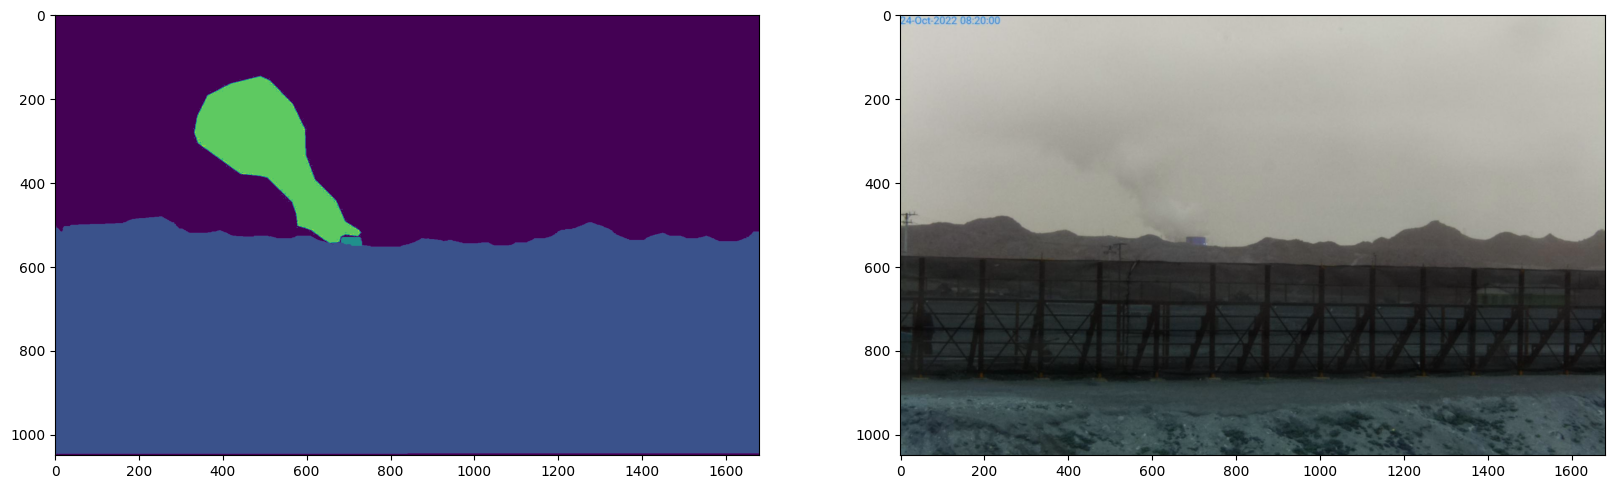

In [36]:
#Recordar que las mascaras estan multiplicadas x75, para poder ver de mejor manera como imagen normal
segment_prueba = cv2.imread('yTest/dispersion_lateral_1_jpg.rf.a697b2d5514acd0855adae3f075d51be.jpg', 0)

#------------- Metodo de Tramitancia -------------#
fig, ax = plt.subplots(1, 2, figsize = (20, 20))
ax[0].imshow(segment_prueba)
ax[1].imshow(imagen_prueba)
plt.show()

-------- Descripcion Estadistica --------
Opacidad Minima: 0.0056
Opacidad Promedio: 0.0986
Q1 de Opacidad: 0.0618
Q2 de Opacidad: 0.0955
Q3 de Opacidad: 0.1292
Opacidad Maxima: 0.5
-----------------------------------------


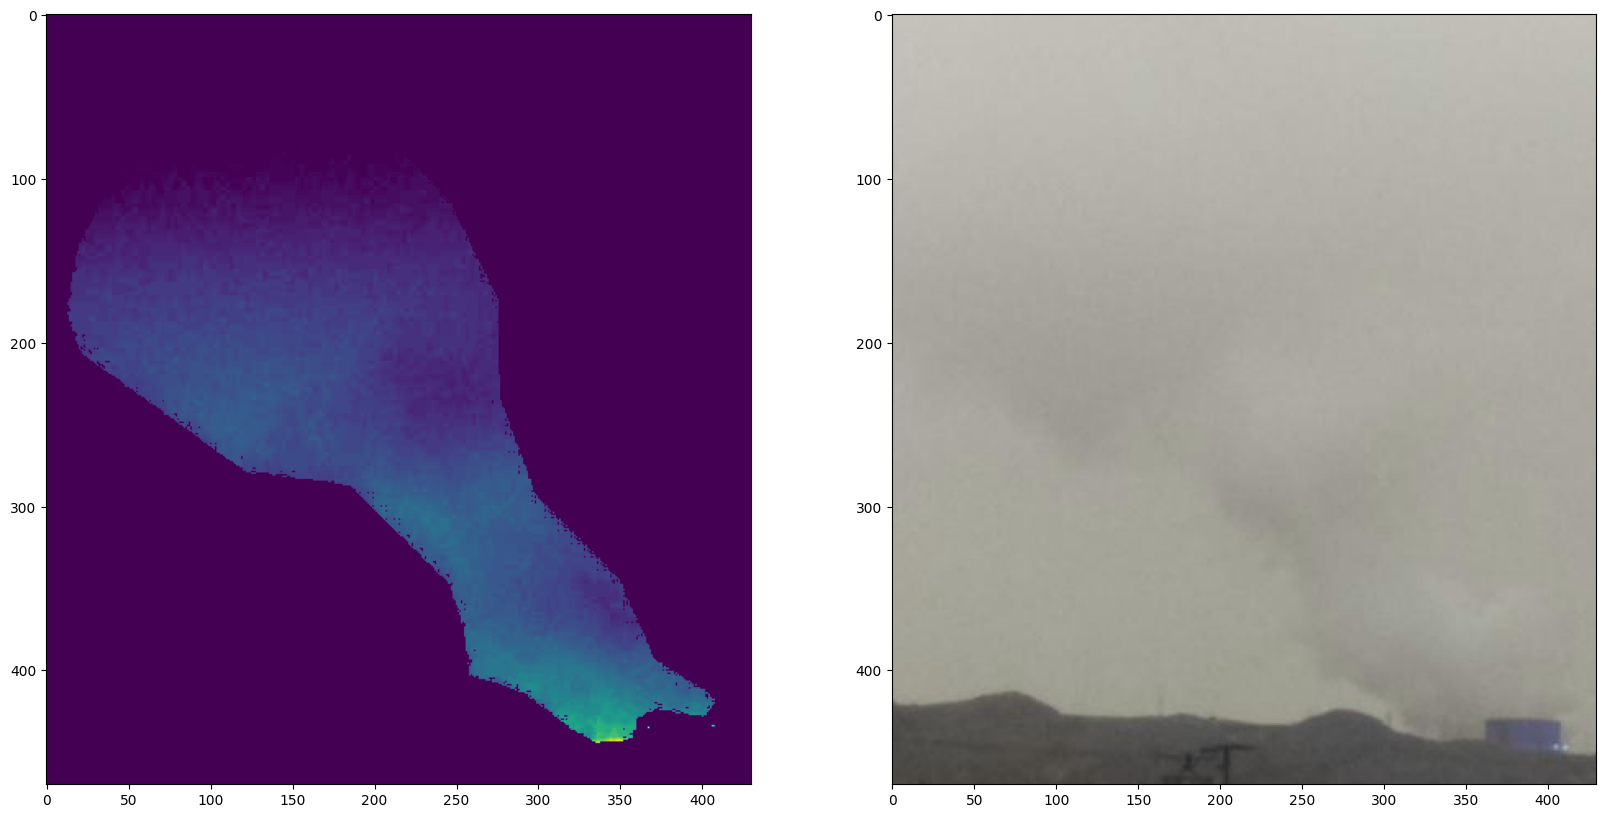

In [37]:
#------------- Metodo de Tramitancia -------------#
fig, ax = plt.subplots(1, 2, figsize = (20, 20))
ax[0].imshow(opacity_tramittance(segment_prueba, imagen_prueba)[100 : 570, 320 : 750])
ax[1].imshow(imagen_prueba[100 : 570, 320 : 750])
plt.show()

-------- Descripcion Estadistica --------
Opacidad Minima: 0.006
Opacidad Promedio: 0.1129
Q1 de Opacidad: 0.0666
Q2 de Opacidad: 0.107
Q3 de Opacidad: 0.1474
Opacidad Maxima: 0.5915
-----------------------------------------


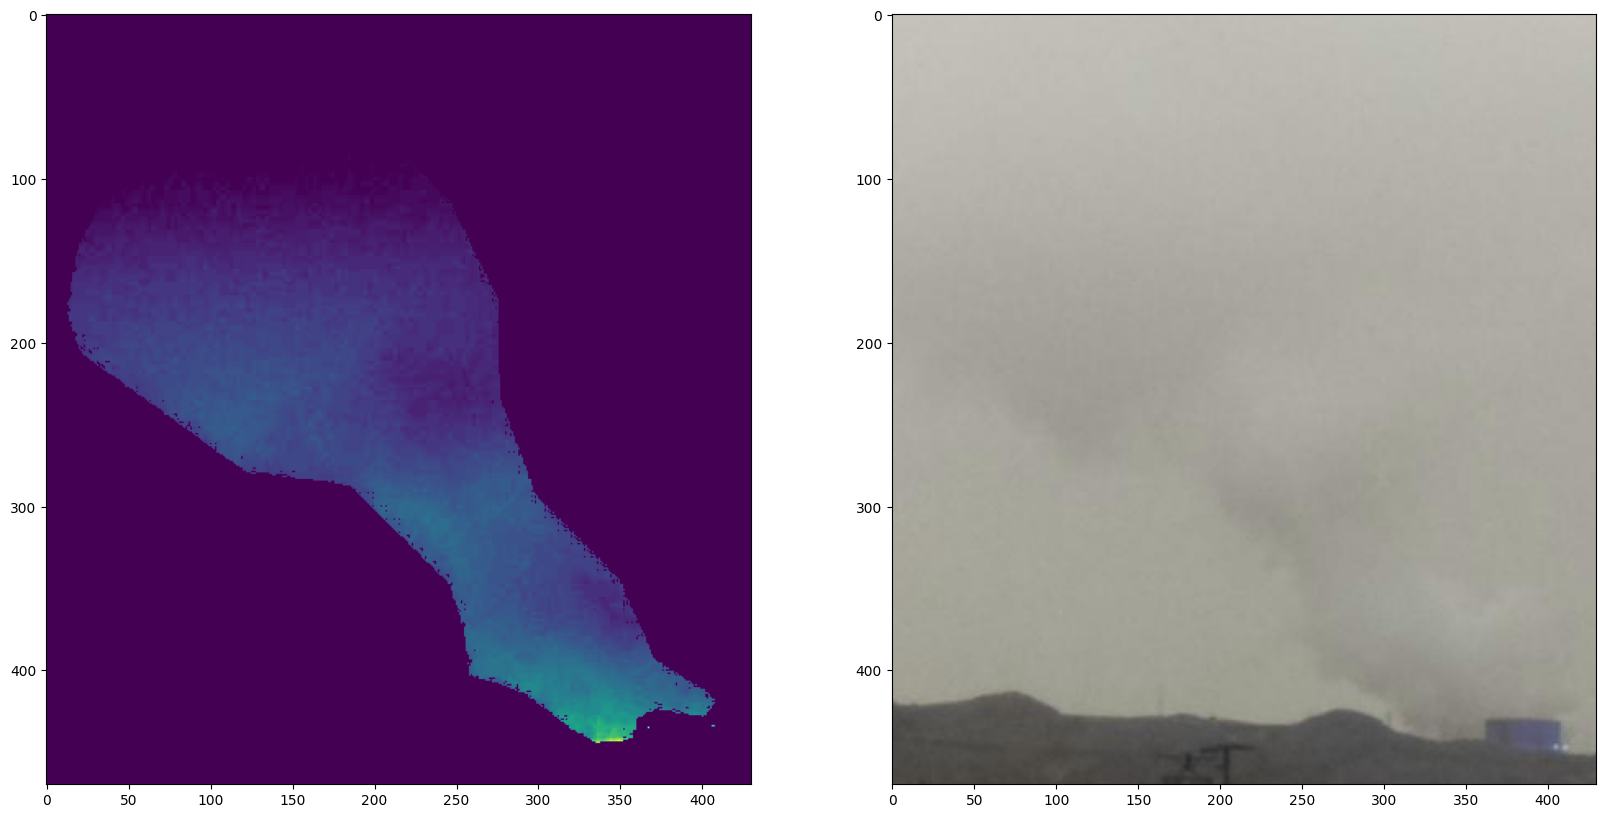

In [38]:
#------------- Metodo de DOM -------------#
fig, ax = plt.subplots(1, 2, figsize = (20, 20))
ax[0].imshow(opacity_dom(segment_prueba, imagen_prueba, 0.16)[100 : 570, 320 : 750])
ax[1].imshow(imagen_prueba[100 : 570, 320 : 750])
plt.show()

-------- Descripcion Estadistica --------
Opacidad Minima: 0.0297
Opacidad Promedio: 0.2677
Q1 de Opacidad: 0.198
Q2 de Opacidad: 0.2673
Q3 de Opacidad: 0.3267
Opacidad Maxima: 1.0
-----------------------------------------


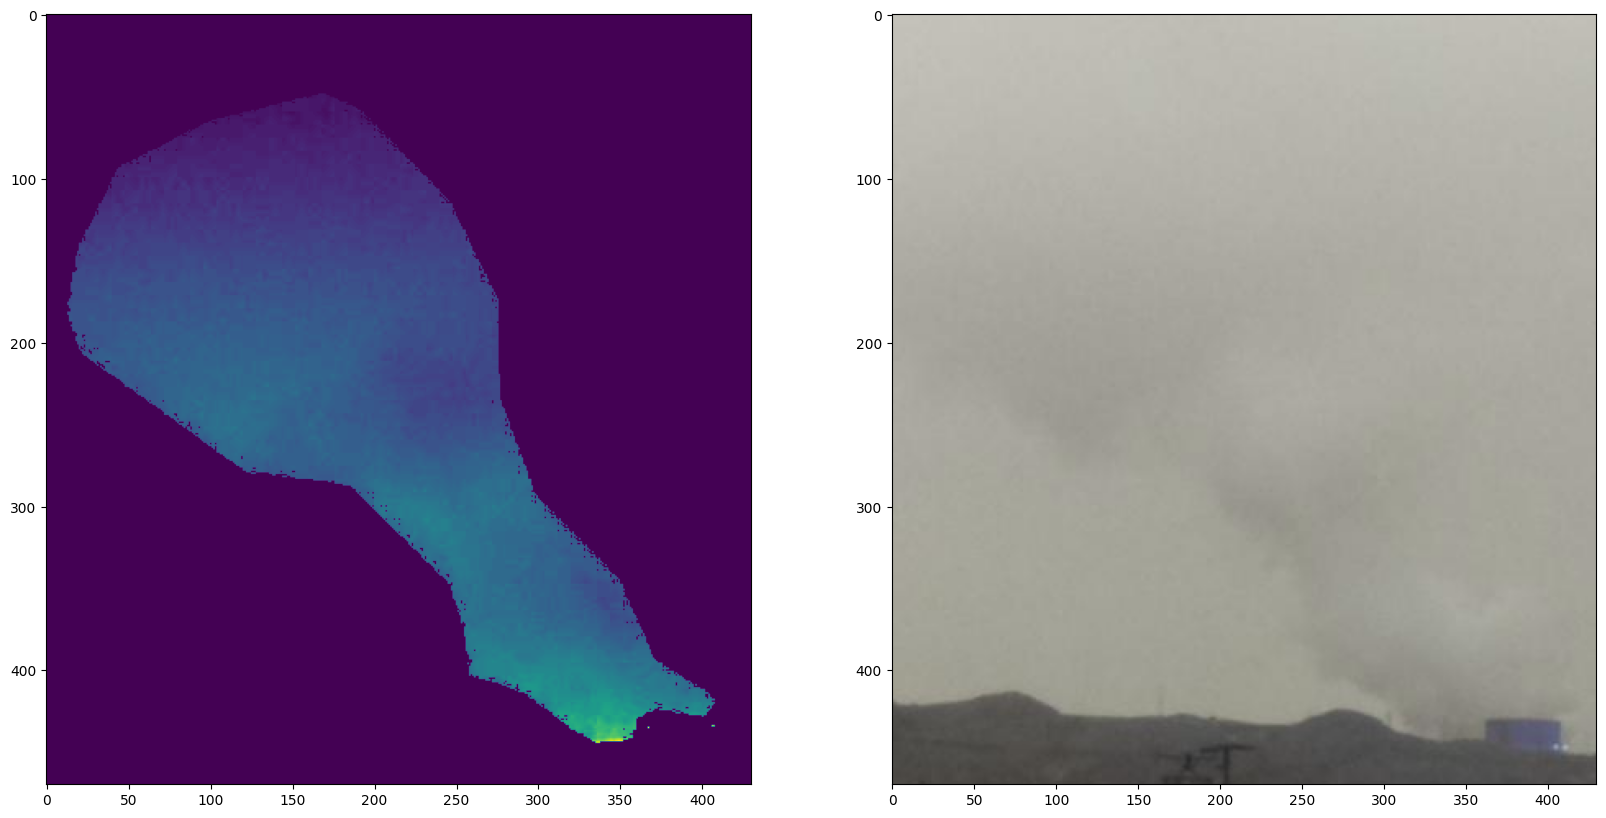

In [39]:
#------------- Metodo SBPB -------------#
fig, ax = plt.subplots(1, 2, figsize = (20, 20))
ax[0].imshow(opacity_sbpb(segment_prueba, imagen_prueba)[100 : 570, 320 : 750])
ax[1].imshow(imagen_prueba[100 : 570, 320 : 750])
plt.show()

Mean of empty slice.
invalid value encountered in scalar divide


-------- Descripcion Estadistica --------
Opacidad Minima: 1.0
Opacidad Promedio: 1.0
Q1 de Opacidad: 1.0
Q2 de Opacidad: 1.0
Q3 de Opacidad: 1.0
Opacidad Maxima: 1.0
-----------------------------------------


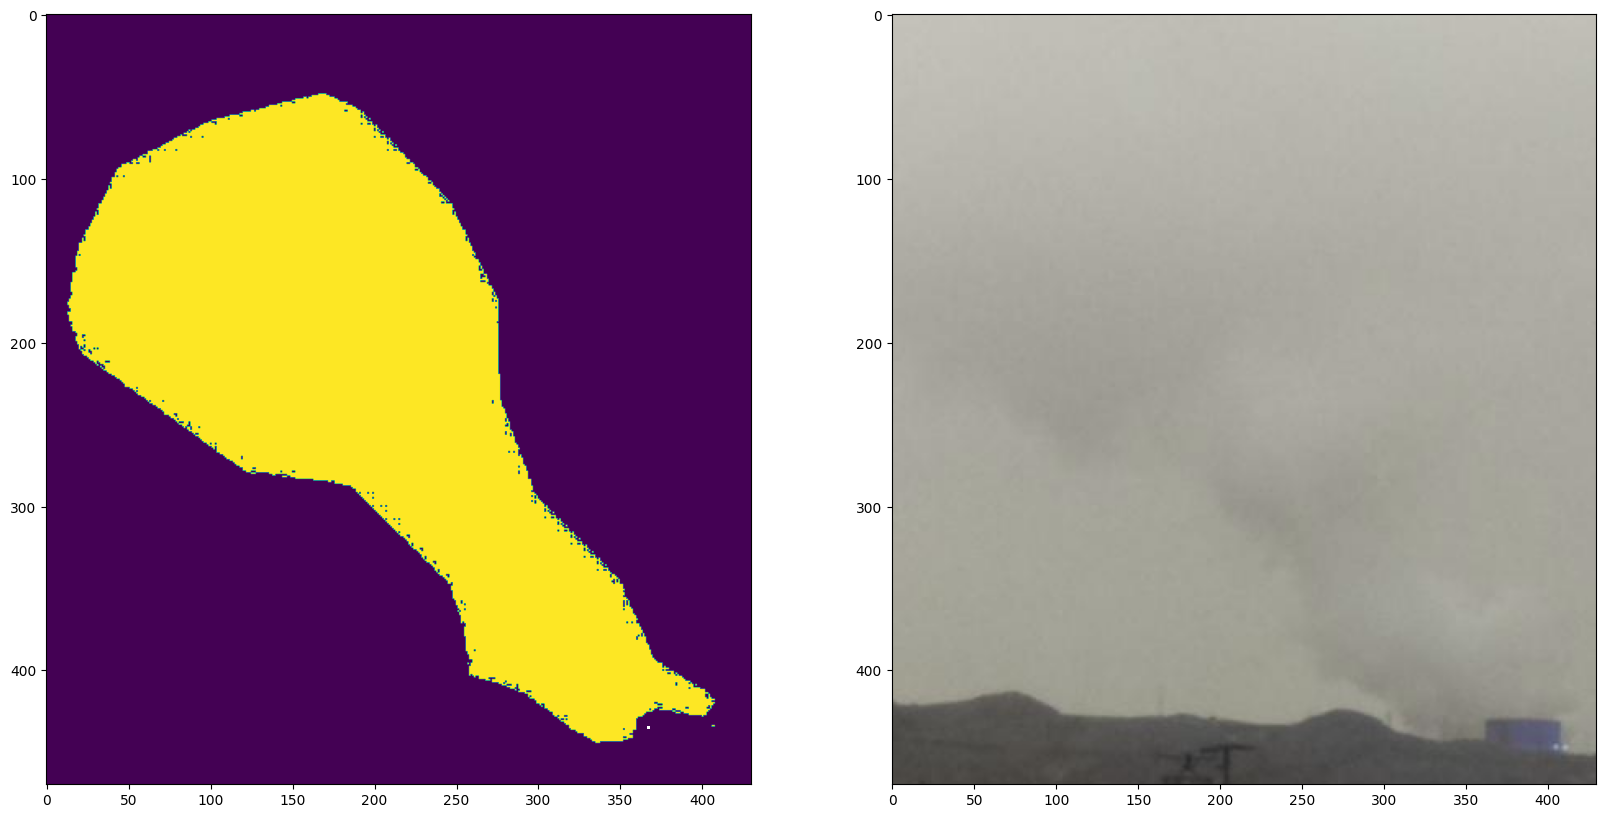

In [40]:
#------------- Metodo Prakasa -------------#
fig, ax = plt.subplots(1, 2, figsize = (20, 20))
ax[0].imshow(opacity_prakasa(segment_prueba, imagen_prueba)[100 : 570, 320 : 750])
ax[1].imshow(imagen_prueba[100 : 570, 320 : 750])
plt.show()

### Bounding Box

<hr>

Para formar el bounding box, usando la mascara del penacho (como arriba), usamos la función `cv2.findContours()` para encontrar las coordenadas del contorno del polígono, y luego usar la función `cv2.boundingRect()` con estas coordenadas para encontrar el bounding box optimo.

In [41]:
def bounding_box_segmentation(imagen, mask, label = None):
  #Generamos una copia de la imagen
  image = imagen.copy()
  #Tomamos la mascara
  smoke = np.where(mask == 3, 1, 0)
  smoke = smoke.astype(np.uint8)
  #Recuperacion de los contornos
  contornos, _ = cv2.findContours(smoke, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #Recorremos los contornos
  for contour in contornos:
    #Obtenemos la caja
    x, y, w, h = cv2.boundingRect(contour)
    vector = (x, y, x + w, y + h)
    #Dibujamos
    plot_one_box(vector, image, [51, 0, 102], label)
  return image

def plot_one_box(x, img, color, label, line_thickness = 3):
    #Grosor de la caja
    tl = line_thickness
    #Coordenadas
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    #Dibujo del rectangulo
    cv2.rectangle(img, c1, c2, color, thickness = tl, lineType = cv2.LINE_AA)
    #Si hay label, agregar texto
    if label:
        tf = max(tl - 1, 1)
        t_size = cv2.getTextSize(label, 0, fontScale = tl / 3, thickness = tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness = tf, lineType = cv2.LINE_AA)



### Resultados Bounding Box

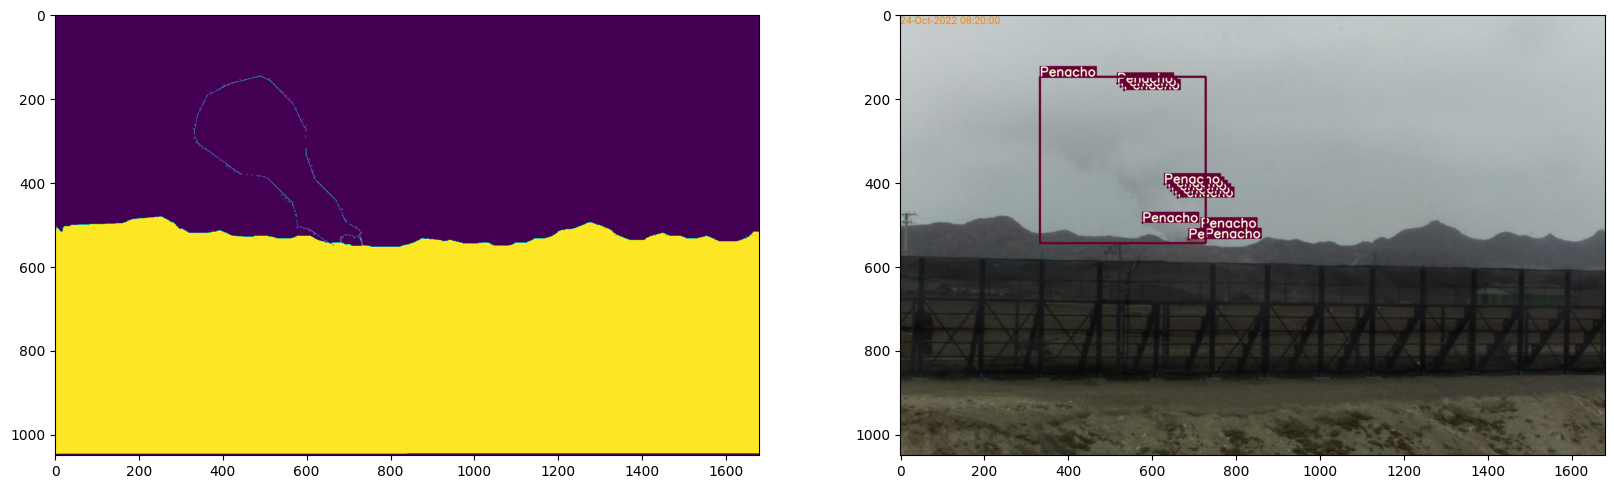

In [42]:
fig, ax = plt.subplots(1, 2, figsize = (20, 20))
ax[0].imshow(np.where(segment_prueba == 1, 1, 0))
ax[1].imshow(cv2.cvtColor(bounding_box_segmentation(imagen_prueba, segment_prueba, 'Penacho'), cv2.COLOR_BGR2RGB))
plt.show()

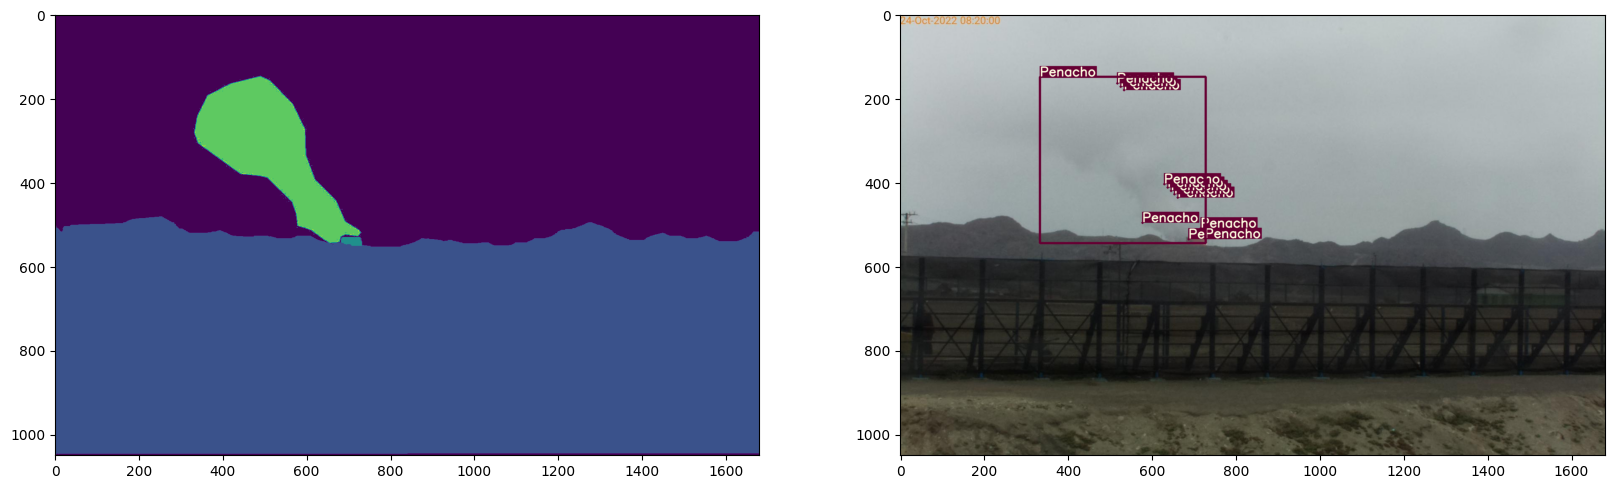

In [43]:
fig, ax = plt.subplots(1, 2, figsize = (20, 20))
ax[0].imshow(segment_prueba)
ax[1].imshow(cv2.cvtColor(bounding_box_segmentation(imagen_prueba, segment_prueba, 'Penacho'), cv2.COLOR_BGR2RGB))
plt.show()

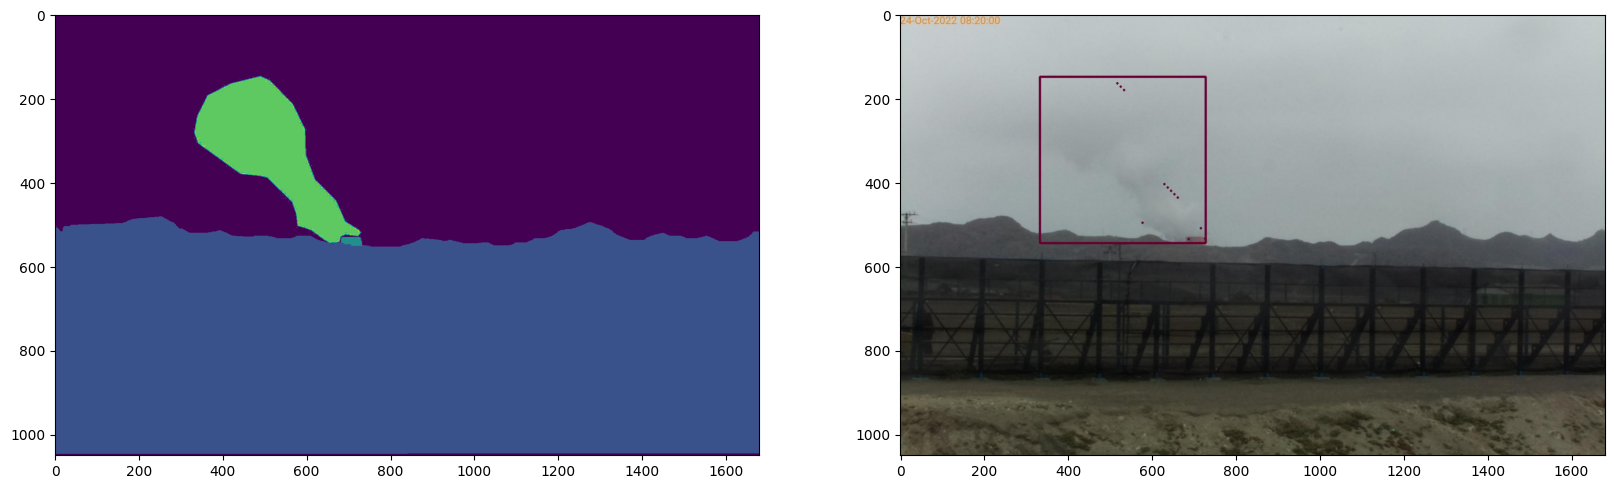

In [44]:
fig, ax = plt.subplots(1, 2, figsize = (20, 20))
ax[0].imshow(segment_prueba)
ax[1].imshow(cv2.cvtColor(bounding_box_segmentation(imagen_prueba, segment_prueba), cv2.COLOR_BGR2RGB))
plt.show()

Falta por ver una función que no permita el overlap, puesto que quedan pixeles sin el valor de la segmentación (lo que debe de ocurrir en el momento de formar la mascara), entonces al momento de formar el bounding box, forma en estos pequeños pixeles vacios, quedando el resultado que se ve arriba.